In [2]:
import time
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import os
import csv
from itertools import cycle
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
# warnings.resetwarnings() # To change it back (optional)

sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.similarity_scores import get_scores
from scripts.nets_and_embeddings import *

In [15]:
# First testing if different embedding methods give result


params = {
    "N": 1000,
    "k": 50,
    "maxk": 100,
    "minc": 5,
    "maxc": 100,
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.2,
}

emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

score_keys = ['kmeans','dbscan', 'optics', 'xmeans', 'infomap', 'flatsbm', 'proposed']

In [20]:
num_cores = 15
runs = np.arange(1, 11)


mu_values = np.round(np.arange(0, 1.05, 0.05),decimals=2)

test_run=False

device_names = [f"cuda:{i}" for i in [0,1,2,3]]  # ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3']

path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_emb_change_{params['N']}_{params['k']}_{params['tau']}"
if test_run:
    path_name += "_test_run"
    
#################### End of Params #################

#if not os.path.isdir(path_name):
#    os.mkdir(path_name)

def create_unique_folder(base_folder):
    if os.path.exists(base_folder):
        index = 1
        while True:
            new_folder = f"{base_folder}_{index}"
            if not os.path.exists(new_folder):
                break
            index += 1
    else:
        new_folder = base_folder

    os.mkdir(new_folder)
    return new_folder
    
path_name = create_unique_folder(path_name)

# Just for this parameter set.
path_name =  "/nobackup/gogandhi/alt_means_sans_k/data/experiment_emb_change_1000_50_3.0"


csv_file_path = path_name + "/result_stream.csv"

print("Hello, you can find results at:\n",path_name)

with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['run_no','emb', 'mu'] + score_keys)

In [ ]:
emb_methods = ['node2vec', 'deepwalk', 'leigenmap', 'modspectralemb', 'nonbackspectralemb']
runs = np.arange(1, 11)
mu_values = np.round(np.arange(0, 1.05, 0.05),decimals=2)


# First let's create networks and embeddings first, and then run clustering:


for run_no in runs:
    
    start_run_time = time.perf_counter()
   
    for emb_method in emb_methods:
        temp_emb_params = deepcopy(emb_params)
        temp_emb_params['method'] = emb_method
    
        start_time = time.perf_counter()
        
        if not os.path.exists(f"{path_name}/Run_{run_no}/"):
            os.mkdir(f"{path_name}/Run_{run_no}/")
        
        for mu in mu_values:
            
            temp_params = deepcopy(params)
            
            temp_params['mu']= mu
            
            net, comm, emb = create_and_save_network_and_embedding(temp_params,temp_emb_params, f"{path_name}/Run_{run_no}/")
            print(run_no, emb_method, mu)
        
        print(f"Emb Method {emb_method} took:{time.perf_counter() - start_time}, avg time per mu_val: {(time.perf_counter() - start_time)/len(mu_values)}") 
        
    print(f"Run took: {time.perf_counter() - start_run_time}")
    

In [27]:
path_name

'/nobackup/gogandhi/alt_means_sans_k/data/experiment_emb_change_1000_50_3.0'

In [56]:
def process_and_save_result(run_no, mu, emb_method, path_name, score_keys, device_name, emb_params, params, csv_file_path):
    start_time = time.perf_counter()


    result_run_mu = get_scores(params, emb_params, score_keys, f"{path_name}/Run_{run_no}/", device_name)
    
    with open(csv_file_path, 'a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([run_no, emb_method, mu] + [result_run_mu[key] for key in score_keys])
        
    elapsed_time = time.perf_counter() - start_time
    
    print(run_no,mu, emb_method, elapsed_time)
    return run_no, mu, result_run_mu

device_names = [f"cuda:{i}" for i in [0,1,2,3]]  # ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3']
emb_methods = ['node2vec', 'deepwalk', 'leigenmap', 'modspectralemb', 'nonbackspectralemb']
runs = np.arange(2, 11)
mu_values = np.round(np.arange(0, 1.05, 0.05),decimals=2)

op_time = time.perf_counter()
for run_no in runs:
    
    start_run_time = time.perf_counter()
   
    for emb_method in emb_methods:
        
        temp_emb_params = deepcopy(emb_params)
        temp_emb_params['method'] = emb_method
    
        start_time = time.perf_counter()
        
        if not os.path.exists(f"{path_name}/Run_{run_no}/"):
            os.mkdir(f"{path_name}/Run_{run_no}/")
        
        for mu, device_name in zip(mu_values,cycle(device_names)):
            
            temp_params = deepcopy(params)
            
            temp_params['mu']= mu
            run_no, mu, result_run_mu = process_and_save_result(run_no, mu, emb_method, path_name, score_keys, device_name, temp_emb_params, temp_params, csv_file_path)
        
        print(f"Emb Method {emb_method} took:{time.perf_counter() - start_time}, avg time per mu_val: {(time.perf_counter() - start_time)/len(mu_values)}") 
        
    print(f"Run took: {time.perf_counter() - start_run_time}")
    
print("Everything took: ", (time.perf_counter() - op_time)/3600)

2 0.0 node2vec 4.229314178228378
2 0.05 node2vec 4.528935115784407
2 0.1 node2vec 4.657626748085022
2 0.15 node2vec 6.178723042830825
2 0.2 node2vec 7.782901383936405
2 0.25 node2vec 5.308530382812023
2 0.3 node2vec 5.477804414927959
2 0.35 node2vec 5.932547366246581
2 0.4 node2vec 6.3533720802515745
2 0.45 node2vec 6.343867041170597
2 0.5 node2vec 24.555959021672606
2 0.55 node2vec 6.945269325748086
2 0.6 node2vec 7.785874513909221
2 0.65 node2vec 10.059770485386252
2 0.7 node2vec 9.46304777637124
2 0.75 node2vec 9.254694217815995
2 0.8 node2vec 10.922136262059212
2 0.85 node2vec 12.028272837400436
2 0.9 node2vec 11.809780279174447
2 0.95 node2vec 12.429207617416978
2 1.0 node2vec 12.350750794634223
Emb Method node2vec took:184.40123376995325, avg time per mu_val: 8.781011316570497
2 0.0 deepwalk 4.5212700590491295
2 0.05 deepwalk 4.6478546392172575
2 0.1 deepwalk 5.216182364150882
2 0.15 deepwalk 5.131478605791926
2 0.2 deepwalk 5.7681386154145
2 0.25 deepwalk 5.94403656385839
2 0.3 

3 0.6 nonbackspectralemb 7.197338204830885
3 0.65 nonbackspectralemb 8.070938309654593
3 0.7 nonbackspectralemb 8.35311940126121
3 0.75 nonbackspectralemb 10.917008919641376
3 0.8 nonbackspectralemb 14.538394642993808
3 0.85 nonbackspectralemb 13.444910205900669
3 0.9 nonbackspectralemb 16.492734303697944
3 0.95 nonbackspectralemb 13.167750902473927
3 1.0 nonbackspectralemb 12.014562852680683
Emb Method nonbackspectralemb took:176.71746689267457, avg time per mu_val: 8.41511762700975
Run took: 851.2597047910094
4 0.0 node2vec 4.078237695619464
4 0.05 node2vec 4.522034892812371
4 0.1 node2vec 4.801649713888764
4 0.15 node2vec 4.81348635815084
4 0.2 node2vec 5.044154582545161
4 0.25 node2vec 5.131459478288889
4 0.3 node2vec 5.640213185921311
4 0.35 node2vec 5.6822694055736065
4 0.4 node2vec 6.10489733889699
4 0.45 node2vec 6.81513424217701
4 0.5 node2vec 6.596826147288084
4 0.55 node2vec 6.891079636290669
4 0.6 node2vec 7.150957591831684
4 0.65 node2vec 8.012352561578155
4 0.7 node2vec 1

5 0.0 nonbackspectralemb 3.989389594644308
5 0.05 nonbackspectralemb 4.785603543743491
5 0.1 nonbackspectralemb 4.546405175700784
5 0.15 nonbackspectralemb 4.98739611171186
5 0.2 nonbackspectralemb 5.432769820094109
5 0.25 nonbackspectralemb 5.176010064780712
5 0.3 nonbackspectralemb 5.8544619884341955
5 0.35 nonbackspectralemb 6.047182995826006
5 0.4 nonbackspectralemb 5.677664799615741
5 0.45 nonbackspectralemb 5.901714542880654
5 0.5 nonbackspectralemb 5.964870970696211
5 0.55 nonbackspectralemb 6.679902533069253
5 0.6 nonbackspectralemb 7.604472313076258
5 0.65 nonbackspectralemb 8.485088054090738
5 0.7 nonbackspectralemb 8.841040762141347
5 0.75 nonbackspectralemb 12.020530551671982
5 0.8 nonbackspectralemb 12.448190482333302
5 0.85 nonbackspectralemb 13.093751024454832
5 0.9 nonbackspectralemb 11.913829132914543
5 0.95 nonbackspectralemb 12.423510175198317
5 1.0 nonbackspectralemb 12.162068374454975
Emb Method nonbackspectralemb took:164.03922033682466, avg time per mu_val: 7.811

7 0.55 modspectralemb 7.144753765314817
7 0.6 modspectralemb 6.938356960192323
7 0.65 modspectralemb 7.487686695531011
7 0.7 modspectralemb 8.855433139950037
7 0.75 modspectralemb 11.235602485015988
7 0.8 modspectralemb 11.912282723933458
7 0.85 modspectralemb 12.466736262664199
7 0.9 modspectralemb 14.610611580312252
7 0.95 modspectralemb 20.717129005119205
7 1.0 modspectralemb 14.735238561406732
Emb Method modspectralemb took:177.7474407684058, avg time per mu_val: 8.464163997521004
7 0.0 nonbackspectralemb 4.091952921822667
7 0.05 nonbackspectralemb 4.879647724330425
7 0.1 nonbackspectralemb 4.472642112523317
7 0.15 nonbackspectralemb 4.832032905891538
7 0.2 nonbackspectralemb 5.054022068157792
7 0.25 nonbackspectralemb 5.188898937776685
7 0.3 nonbackspectralemb 5.400018226355314
7 0.35 nonbackspectralemb 5.516199097037315
7 0.4 nonbackspectralemb 5.719715209677815
7 0.45 nonbackspectralemb 6.191534848883748
7 0.5 nonbackspectralemb 6.2840816881507635
7 0.55 nonbackspectralemb 6.514

9 0.0 modspectralemb 5.365266161039472
9 0.05 modspectralemb 5.085801878944039
9 0.1 modspectralemb 4.839212840422988
9 0.15 modspectralemb 5.500682542100549
9 0.2 modspectralemb 5.268406407907605
9 0.25 modspectralemb 8.325295710936189
9 0.3 modspectralemb 5.368180904537439
9 0.35 modspectralemb 6.622429260984063
9 0.4 modspectralemb 6.168926822021604
9 0.45 modspectralemb 6.373654555529356
9 0.5 modspectralemb 6.462999511510134
9 0.55 modspectralemb 6.715038374066353
9 0.6 modspectralemb 7.415705384686589
9 0.65 modspectralemb 7.396119510754943
9 0.7 modspectralemb 8.358894439414144
9 0.75 modspectralemb 10.04536453075707
9 0.8 modspectralemb 11.864323571324348
9 0.85 modspectralemb 12.589701611548662
9 0.9 modspectralemb 11.56839899905026
9 0.95 modspectralemb 10.801652371883392
9 1.0 modspectralemb 12.128062209114432
Emb Method modspectralemb took:164.26697227358818, avg time per mu_val: 7.822237119344728
9 0.0 nonbackspectralemb 4.1077007204294205
9 0.05 nonbackspectralemb 4.52164

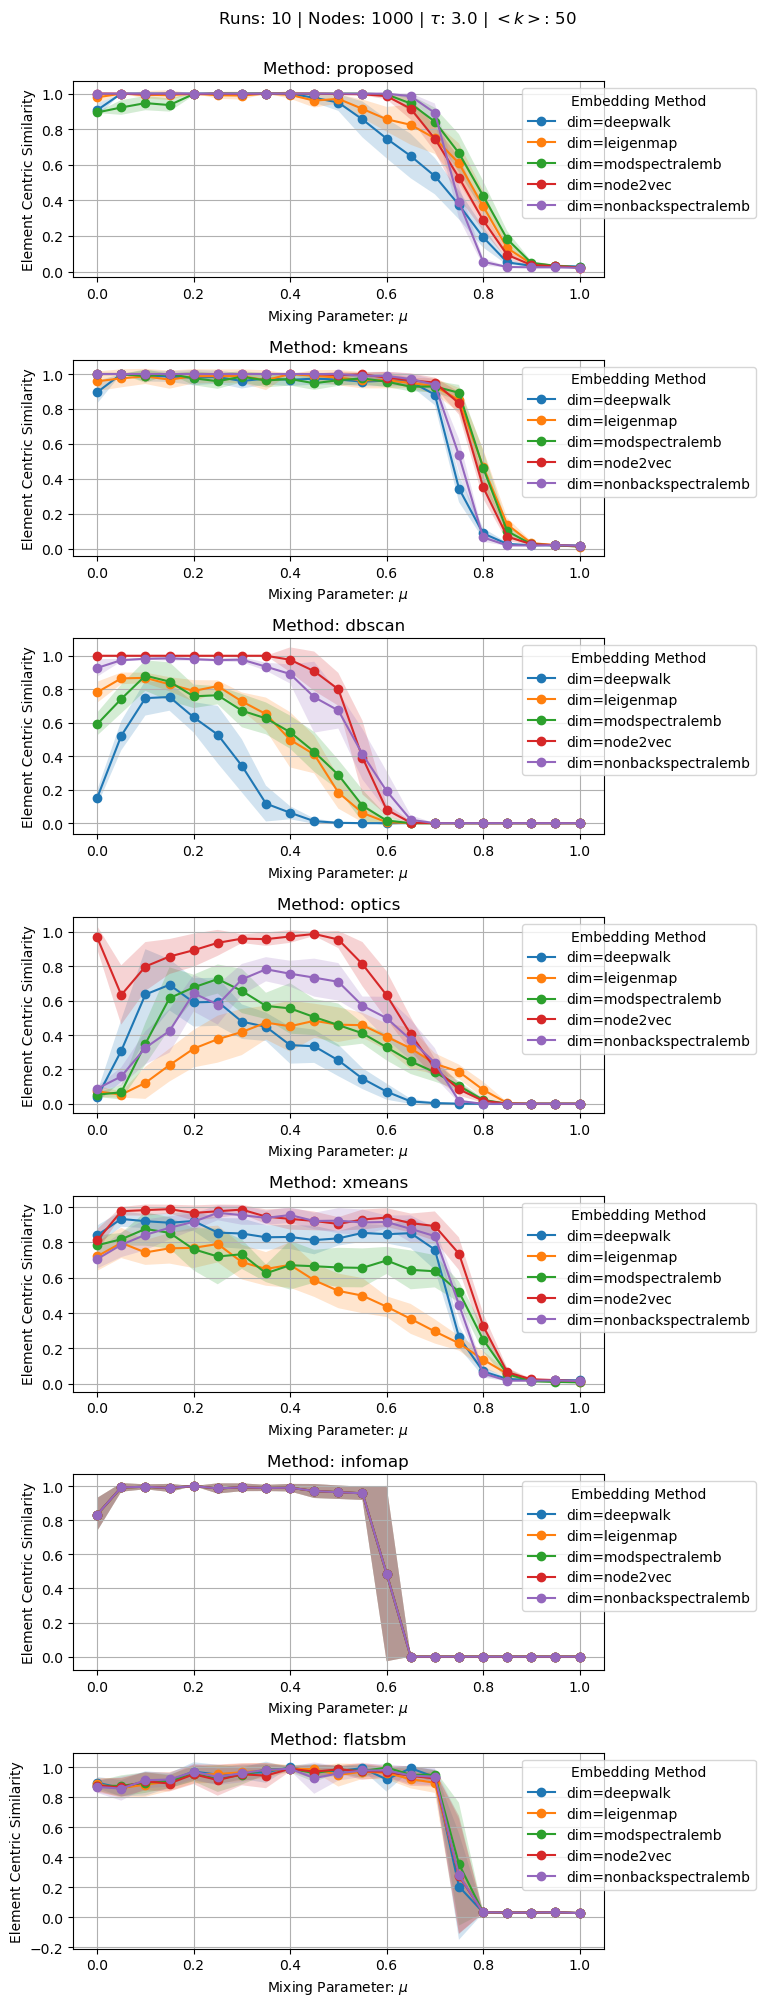

In [87]:
import matplotlib.pyplot as plt
#def plotting_mu_change(path_name, params):

csv_file_path = path_name + "/result_stream.csv"

result_df = pd.read_csv(csv_file_path)
runs = result_df['run_no'].unique()
df_grouped = result_df.groupby(['mu', 'emb']).agg(['mean', 'std'])

# Create subplots
fig, axes = plt.subplots(len(score_keys), 1, figsize=(8, 20))

# Plot for the "proposed" column

for i in range(-1, -1 + len(axes)):
    ax0 = axes[i+1]
    for dim_value in df_grouped.index.levels[1]:
        index = [i for i,j in list(df_grouped.loc(axis=0)[:, dim_value]['kmeans']['mean'].index)]
        mean_values = df_grouped.loc(axis=0)[:, dim_value][score_keys[i]]['mean']
        std_values = df_grouped.loc(axis=0)[:, dim_value][score_keys[i]]['std']

        ax0.plot(index, mean_values, '-o', label=f'dim={dim_value}')
        ax0.fill_between(index, mean_values - std_values, mean_values + std_values, alpha=0.2)

    ax0.set_xlabel(r'Mixing Parameter: $\mu$')
    ax0.set_ylabel(f"Element Centric Similarity")
    ax0.legend(title="Embedding Method", loc='upper right', bbox_to_anchor=(1.3, 1))
    ax0.grid(True)
    ax0.set_title(f"Method: {score_keys[i]}")
    
plt.suptitle(rf'Runs: {len(runs)} | Nodes: {params["N"]} | $\tau$: {params["tau"]} | $<k>$: {params["k"]}',y=1.001)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"{path_name}/changing_embeddings_plot.png", bbox_inches='tight')
#plt.close()

#    returnzv

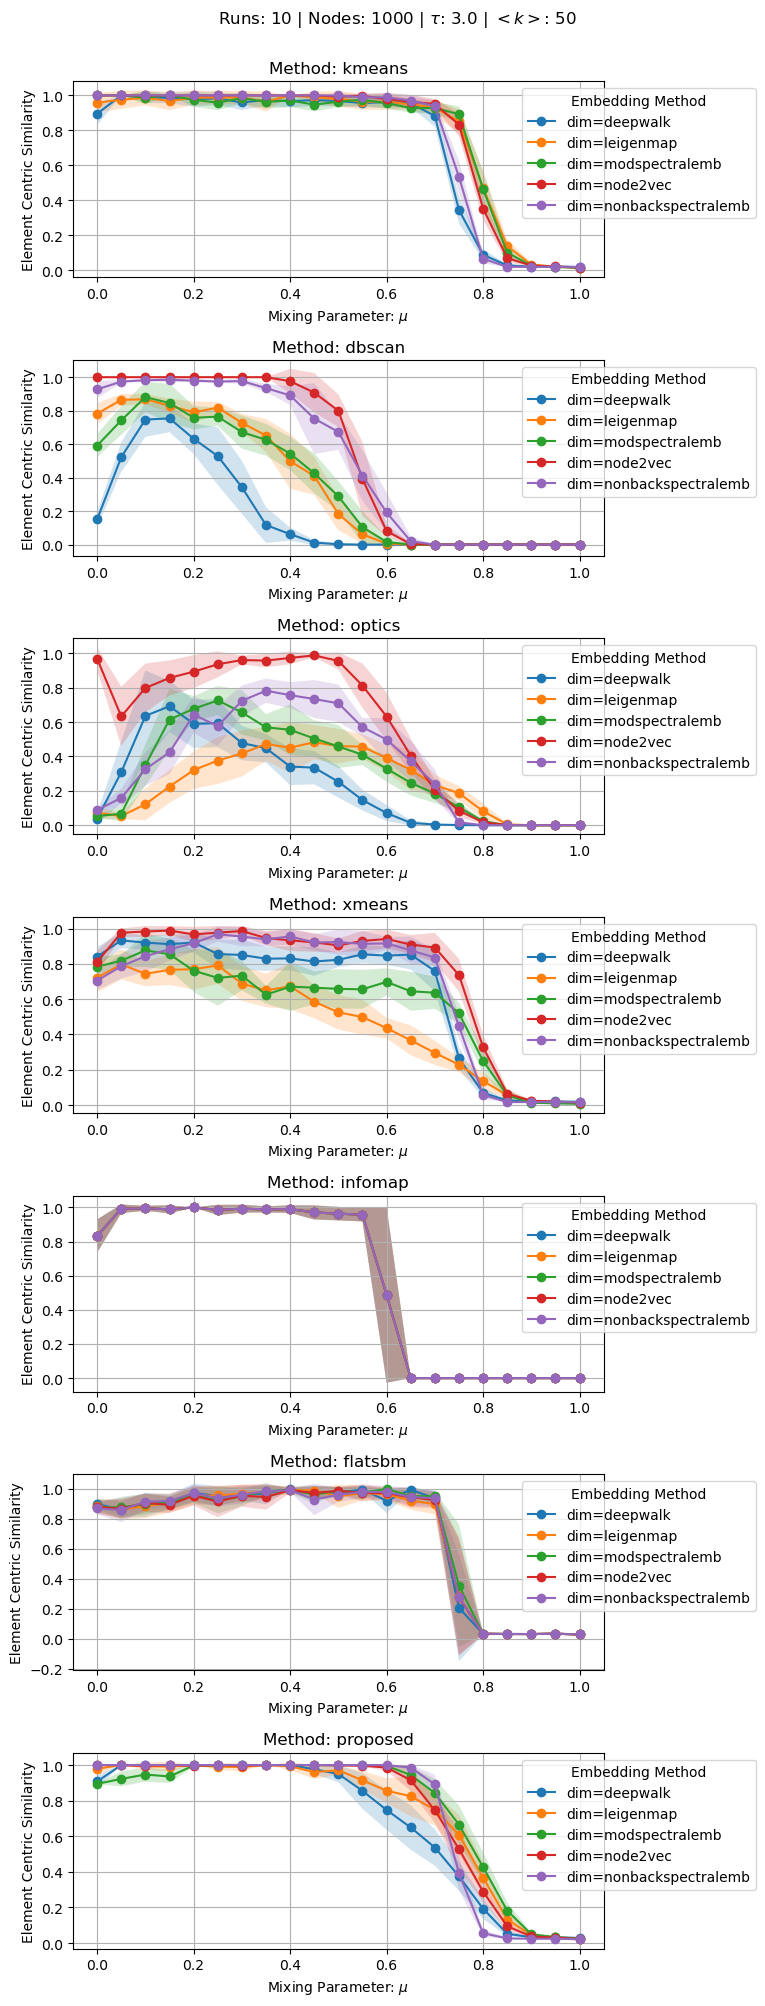

In [52]:
# # Regenerating a corrupted file:
# temp_emb_params = deepcopy(emb_params)
# temp_emb_params['method'] = "nonbackspectralemb"
# temp_params = deepcopy(params)
# temp_params['mu']= 0.85

# net, comm, emb = create_and_save_network_and_embedding(temp_params,temp_emb_params, f"{path_name}/Run_{1}/")
# # Testing it
# for method in emb_methods:
#     for r in runs:
#         for mu_val in mu_values:
#             try:
#                 emb = np.load(f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_emb_change_1000_50_3.0/Run_{r}/emb_LFR_n_1000_tau1_3.0_tau2_1.0_mu_{mu_val}_k_50_mincomm_5_{method}_window_length_10_dim_64.npz")['emb']    

#             except:
#                 print(r, mu_val)

In [57]:
score_keys

['kmeans', 'dbscan', 'optics', 'xmeans', 'infomap', 'flatsbm', 'proposed']